In [1]:
## Code updated from RandomWalk_2020-04-01.jl

In [2]:
using Pkg;
Pkg.activate(".")

"/Users/mcfefa/Dropbox/Papers in Progress/Diversity-Score-Theory-Paper/code/Project.toml"

In [3]:
using Random
using Plots
using Statistics

┌ Info: Recompiling stale cache file /Users/mcfefa/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


In [32]:
using Dates

In [4]:
## Create initial conditions
   # input: number of cells, initial clones, will randomly assign initial frequency 

function makeInitialPayoff(clones::Int64, fillPayoff::Vector, freqSel::Bool=false)
    # ... is vararg splat, takes an array of values and passes them to a function as if 1st, 2nd, 3rd
    # converts an array into arguments

    if freqSel
      payoff = fillPayoff.*rand(clones,clones)
    else
      payoff = hcat(fill(fillPayoff, (clones,1))...)
    end
    
    return payoff::Matrix
end


makeInitialPayoff (generic function with 2 methods)

In [5]:
function initialize(cellCount::Int64, numClones::Int64, fillPayoff::Vector, freqSel::Bool=false)
    # initialize what each cell is 
    
    totalCells = rand(1:numClones,cellCount); # assigning clones to each spot
    payoff = makeInitialPayoff(numClones, fillPayoff, freqSel)
    
    return (totalCells, payoff); 
end

initialize (generic function with 2 methods)

In [6]:
function calcFreq(uniqueClones::Vector{Int64}, perClone::Vector{Int64})
    # calculates frequency of each unique clone at current time point
    
    ### ASK JAMES FOR A WORD DESCRIPTION OF X->X=i ...
    
    cts = [count(x->x==i,perClone) for i in uniqueClones]
    return cts/sum(cts)
end

calcFreq (generic function with 1 method)

In [7]:
## Create payoff matrix -- add row/column

function makeNewClone(mtx::Matrix, parent::Int64, freqSel::Bool=false)
    
    ## add or delete depending on if new clone is added or removed from population
    # to add, make a new matrix of [n+1, n+1], loop through to fill in old matrix and add new matrix
    
    # note, should be a square matrix, x==y --- use for error handling
    
    (x,y) = size(mtx)
    newMtx = zeros(x+1,x+1)   # creates an empty matrix of zeros
    newMtx[1:x,1:x] = mtx     # fills in the original matrix
    
    if freqSel
        # FREQUENCY SELECTION
        # returns clone that will produce the new clone
        # perturb by the mean with std proportional to mean
        newMtx[x+1,1:x] = mtx[parent,:].*(1 .+ 0.01*randn(x))      
        ## fill last elements of row 
        # calculate the mean of the rows to fill in for the new clone 
        rowMean = mean(newMtx[1:x,1:x],dims=2)
        for i in 1:x
            newMtx[i,x+1] = rowMean[i]
        end
    else
        # CONSTANT SELECTION 
        newOne = mtx[parent,1]*(1+randn()) # all the same across the row, 
        newMtx[x+1,:] = fill(newOne,x+1)   # fill in constant selection for new species
        for i in 1:x
              newMtx[i,x+1] = newMtx[i,x]
        end
    end 
    
    return newMtx/maximum(newMtx)
end

makeNewClone (generic function with 2 methods)

In [8]:
## Create payoff matrix -- remove row/column

function deleteClone(mtx::Matrix{Float64}, remove::Int64)
    
    ## add or delete depending on if new clone is added or removed from population
    # to delete, just delete row and column of interest
    
    return mtx[1:end .!= remove, 1:end .!= remove]
end


deleteClone (generic function with 1 method)

In [9]:
function calcAvgFitness(payoff::Matrix{Float64}, freq::Vector{Float64})
    # multiply the frequencies by the payoff matrix to calculate the average fitness   
    # xT*A*x
    
    expectedPayoff = payoff*freq
    
    # return (transpose(freq)*Epayoff, Epayoff) 
    return (freq'*expectedPayoff, expectedPayoff) 
end

calcAvgFitness (generic function with 1 method)

In [10]:
function probReplication(payoff::Matrix{Float64}, freq::Vector{Float64}, intensity::Float64)
    
    # calculating the probability that a clone replicates
    # inputs: payoff matrix (Matrix)
    #         frequency of the clones (Vector)
    #         selection intensity (Real)
    # output: probability 
    
    (avg, expectedPayoff) = calcAvgFitness(payoff,freq);

    # Species rate of production of offspring
    probRep = exp.(intensity*(expectedPayoff)).*freq  #  .- avg
    # @show probRep

    # Compute CDF
    cs = cumsum(probRep)
    prob = cs/cs[end]
    
    # returns grouping of which proportion will be replicating when random number
    return prob
end

probReplication (generic function with 1 method)

In [11]:
function calcqD(freq::Vector{Float64}, res::Int64=1000)
  ## good default resoluion: 1000
  ## TO DO: add if q == 1 correction 

  q = exp10.(range(-2.0, stop=2.0, length=res));
  qD = sum(freq.^q', dims=1) .^ (1 ./ (1 .- q'))
  return (qD[:], q)
end

calcqD (generic function with 2 methods)

In [12]:
function runSim(initialPayoff::Vector{Float64}, totGen::Int64, cellCount::Int64, numClones::Int64, intensity::Float64, mutProb::Float64, howOftenCalcQD::Int64, resQD::Int64=1000, freqSelOn::Bool=false)
    
    # inputs: 
    #   initialPayoff::Vector{Float64} - fill vector 
    #   totGen::Int64 - number of generations to loop over
    #   cellCount::Int64 - total number of cells/total population size
    #   numClones::Int64 - number of distinct clones
    #   intensity::Float64 - selection intensity
    #   mutProb:: Float64 - probability a clone mutates 
    #   delay::Int64 - after delay steps, start calculating qD  !!!! TO DO !!!!
    #   howOftenCalcQD::Int64 - calculate qD every howOftenCalcQD timesteps
    #   resQD::Int64 - resolution at which qD is calculated, defaults to 1000 
    
    # Create the initial payoff matrix, based on cellCount & numClones
    # initialize the initial conditions
    # make individual cells with which clone they are and the initial payoff matrix
    (cells, payoff) = initialize(cellCount, numClones, initialPayoff, freqSelOn);
    totClones = numClones;
    uniqueClones = Array(1:numClones)
    numClonesTrack = zeros(Int,totGen);
    numClonesTrack[1] = numClones;
    
    # create array for collecting --- ASK JAMES IF THIS CAN BE IMPROVED ---- ask James what means 
    qDarray = Vector{Float64}[]

    # calculate the frequency of each clone
    freq = calcFreq(uniqueClones,cells)
    qD, qRange = calcqD(freq);
    push!(qDarray, qD)
    whoDied = Tuple{Int, Float64}[]
    
    for gen in 2:totGen

        # Step 1: calculate prob of each clone to be replicating
        # Step 2: find which clone replicates (random number, see who select)
        # Step 3: decide if mutate (rand num)
        # Step 4: decide how much mutates by (offspring close to num in payoff)
   
        # get a cumulative probability distribution (essentially CDF) for probability of replication
        CDF = probReplication(payoff, freq, intensity) 

        # decide which clone replicates
        ####### FIXME ###### (When only single clone )
        roll = rand()
        
        whichOneRep = []
        whichOneRepIndex = []
        try
            # looking for the first time we exceed the role, if so mutates
            whichOneRepIndex = findall(y->(y>=roll),CDF)[1]
            whichOneRep = uniqueClones[whichOneRepIndex]
        catch
            @show freq, payoff, uniqueClones,CDF
            @error("what??")
        end
        
       # println("which one reps ", whichOneRep)
        #once replication occurs, does it mutated
        if (mutProb > rand())
            ## true, add to payoff matrix
            # if you mutate, update payoff, update array of cells and add new cell to total num of clones
            payoff = makeNewClone(payoff, whichOneRepIndex, freqSelOn) 
            numClones +=1
            totClones +=1
            whoReplacesDead = totClones
            push!(uniqueClones, whoReplacesDead)
        else
            ## false - no mutation
            whoReplacesDead = whichOneRep
        end
                    
        # randomly pick who dies (randomly pick a clone, replace with new clone)
        whichCellDies = rand(1:cellCount)
        cells[whichCellDies] = whoReplacesDead
        
        # check to see if a clone is lost --> 0 is a lost clone
        # calculate the frequency of each clone to identify 0 clone
        freq = calcFreq(uniqueClones,cells)
                
        # check if we lost a clone, if yes       
        locZeros = findall(x->x==0,freq)
        # if clone died, record it in whoDied and remove from payoff
        if length(locZeros) > 0
            
            deadClone = locZeros[1]
            # record which clone died and its payoff
            push!(whoDied, (uniqueClones[deadClone], payoff[deadClone,1]))     
            
            # delete dead clone from payoff, freq, and number of clones
            payoff = deleteClone(payoff, deadClone)
            deleteat!(freq,deadClone)
            deleteat!(uniqueClones,deadClone)
            numClones -= 1
            
        end
        
        numClonesTrack[gen] = numClones; 
        if gen % howOftenCalcQD == 0
          qD, _ = calcqD(freq);
          push!(qDarray, qD)
        end
    end
   # currently only returning first column of payoff matrix because all rows are the same
    return (numClonesTrack=numClonesTrack, totClones=totClones, freq=freq, payoff=payoff[:,1], whoDied=whoDied, qD=qDarray, q=qRange)
    
end

runSim (generic function with 3 methods)

In [13]:
    # inputs: 
    #   initialPayoff::Vector{Float64} - fill vector 
    #   totGen::Int64 - number of generations to loop over
    #   cellCount::Int64 - total number of cells/total population size
    #   numClones::Int64 - number of distinct clones
    #   intensity::Float64 - selection intensity
    #   mutProb:: Float64 - probability a clone mutates 
    #   howOftenCalcQD::Int64 - calculate qD every howOftenCalcQD timesteps
    #   resQD::Int64 - resolution at which qD is calculated, defaults to 1000 
    #   freqSelOn::Bool = tells whether on freq dependent selection or constant selection

In [14]:
# outputs: (
#       numClonesTrack=numClonesTrack, 
#       totClones=totClones, 
#       freq=freq, 
#       payoff=payoff[:,1], 
#       whoDied=whoDied, 
#       qD=qDarray, q=qRange
# )

In [33]:
numClones = 1;
mut = 2.0e-3;
cellCount = 1000;
initialPayoff = rand(numClones);
gen=500000;
selInt = 10.0;
howOften = 10000;
resolution = 10000;
freqSelType = false;

In [34]:
resConstSel = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);

In [35]:
resFreqSel = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [53]:
# plot qD curve: 
qdPlot = plot(resConstSel.q,resConstSel.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot, resFreqSel.q,resFreqSel.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot, string("DiversityCurves_selInt-10_mutRate-2e-3_",Dates.today(),".pdf"))

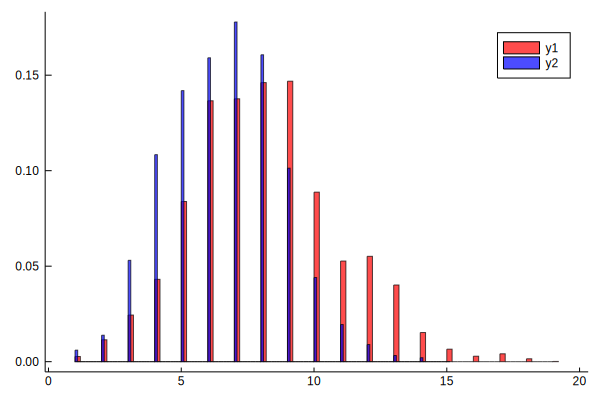

In [54]:
# histogram of number of clones at a time
hPlot = histogram(resConstSel.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.7, grid=false)
histogram!(hPlot, resFreqSel.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.7)

In [38]:
savefig(hPlot, string("Histogram-of-Clones_selInt-10_mutRate-2e-3_",Dates.today(),".pdf"))

In [39]:
mut = 2.0e-1;

In [40]:
resConstSelHiMu = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);

In [41]:
resFreqSelHiMu = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [52]:
# plot qD curve: 
qdPlotHiMu = plot(resConstSelHiMu.q,resConstSelHiMu.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotHiMu, resFreqSelHiMu.q,resFreqSelHiMu.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlotHiMu, string("DiversityCurves_selInt-10_mutRate-2e-1_",Dates.today(),".pdf"))

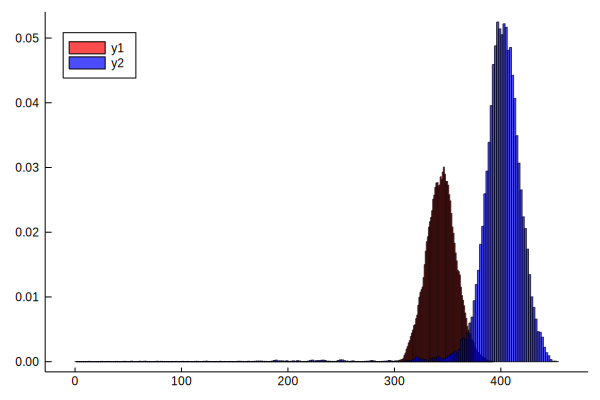

In [57]:
# histogram of number of clones at a time
hPlotHiMu = histogram(resConstSelHiMu.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.7, grid=false)
histogram!(hPlotHiMu, resFreqSelHiMu.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.7, legend=:topleft)

In [58]:
savefig(hPlotHiMu, string("Histogram-of-Clones_selInt-10_mutRate-2e-1_",Dates.today(),".pdf"))

In [60]:
mut = 5e-4;

In [61]:
resConstSelLoMu2 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelLoMu2 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

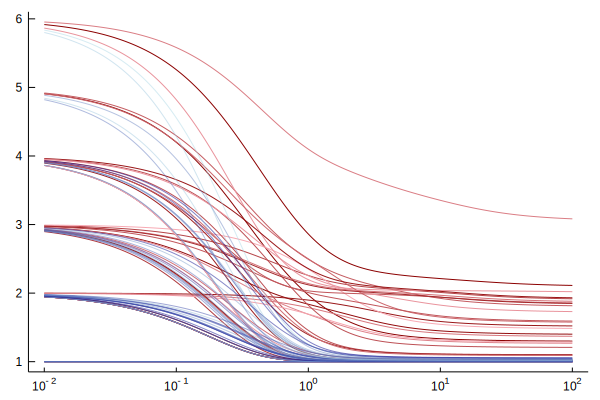

In [89]:
# plot qD curve: 
qdPlotLoMu2 = plot(resConstSelLoMu2.q,resConstSelLoMu2.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotLoMu2, resFreqSelLoMu2.q,resFreqSelLoMu2.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)

In [75]:
savefig(qdPlotLoMu2, string("DiversityCurves_selInt-10_mutRate-5e-4_",Dates.today(),".pdf"))

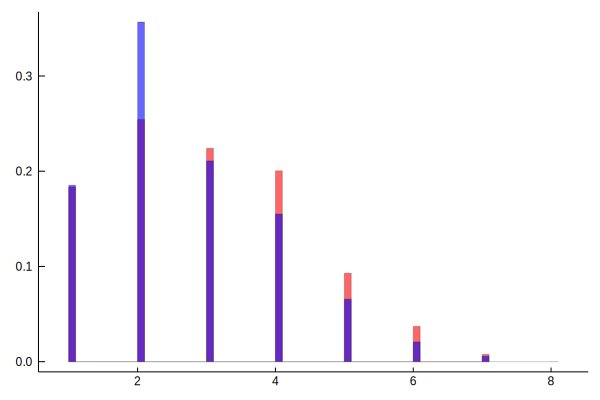

In [84]:
# histogram of number of clones at a time
hPlotLoMu2 = histogram(resConstSelLoMu2.numClonesTrack, bins=:scott, normalize=:probability, color=:red, linealpha=0.2, opacity=0.6, grid=false)
histogram!(hPlotLoMu2, resFreqSelLoMu2.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, linealpha=0.2, opacity=0.6, legend=false)

In [85]:
savefig(hPlotLoMu2, string("Histogram-of-Clones_selInt-10_mutRate-5e-4_",Dates.today(),".pdf"))

In [68]:
mut = 5e-2;

In [65]:
resConstSelHiMu2 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelHiMu2 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [69]:
# plot qD curve: 
qdPlotHiMu2 = plot(resConstSelHiMu2.q,resConstSelHiMu2.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotHiMu2, resFreqSelHiMu2.q,resFreqSelHiMu2.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)

In [ ]:
savefig(qdPlotHiMu2, string("DiversityCurves_selInt-10_mutRate-5e-2_",Dates.today(),".pdf"))

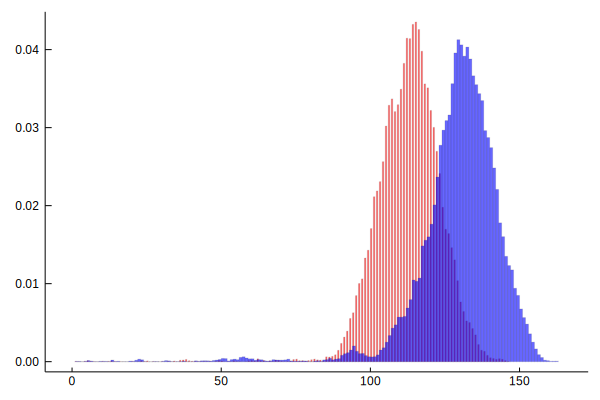

In [86]:
# histogram of number of clones at a time
hPlotHiMu2 = histogram(resConstSelHiMu2.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlotHiMu2, resFreqSelHiMu2.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)

In [87]:
savefig(hPlotHiMu2, string("Histogram-of-Clones_selInt-10_mutRate-5e-2_",Dates.today(),".pdf"))